# Floquet Cavity Cooling - GPU Training

This notebook runs training on Colab GPU.

**IMPORTANT**: After running cell 2, restart the runtime (Runtime > Restart runtime) before continuing!

In [1]:
# Cell 1: Install dependencies
!pip install -q jax[cuda12] jaxlib flax optax diffrax gymnasium stable-baselines3 matplotlib

In [2]:
# GPU monitoring widget (runs in background)
import threading
import time
from IPython.display import clear_output


def monitor_gpu(interval=5, duration=600):
    """Monitor GPU for `duration` seconds, updating every `interval` seconds."""
    import subprocess

    start = time.time()
    while time.time() - start < duration:
        clear_output(wait=True)
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
        print(result.stdout)
        time.sleep(interval)


# Start monitoring in background (optional)
thread = threading.Thread(target=monitor_gpu, args=(5, 300))
thread.start()

# Or just run once:
# !nvidia-smi

Sun Jan  4 01:53:18 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Cell 2: Clone repo and checkout dev branch
# After this cell, RESTART RUNTIME before continuing!
import os
if not os.path.exists('/content/abouie_proj'):
    !git clone https://github.com/sattary/abouie_proj.git /content/abouie_proj
else:
    %cd /content/abouie_proj
    !git fetch origin dev
    !git checkout dev
    !git pull origin dev
    %cd /content

print("\n" + "="*50)
print("NOW RESTART RUNTIME: Runtime > Restart runtime")
print("Then run cells starting from Cell 3")
print("="*50)

Sun Jan  4 01:53:28 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Cell 3: Setup paths (run AFTER restart)
import sys
import os
os.chdir('/content/abouie_proj')
sys.path.insert(0, '/content/abouie_proj')

# Verify files exist
!ls src/
!cat src/physics/__init__.py | head -20

Sun Jan  4 01:53:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Cell 4: Verify GPU
import jax
devices = jax.devices()
print(f"JAX devices: {devices}")
gpu_available = any('cuda' in str(d).lower() or 'gpu' in str(d).lower() for d in devices)
print(f"GPU available: {gpu_available}")
assert gpu_available, "GPU not detected! Enable GPU in Runtime > Change runtime type"

JAX devices: [CudaDevice(id=0)]
GPU available: True


In [6]:
# Cell 5: Import modules
from src.physics import SystemParams, build_operators, thermal_cavity_ground_qubits
from src.floquet import create_constant_cycle, find_floquet_steady_state
from src.baseline import compute_stochastic_limit, StochasticParams
from src.optimization import run_grape_optimization, GRAPEConfig
from src.rl import FloquetCoolingEnv, train_sac
from src.utils import save_grape_results, save_sac_results
print("All imports OK!")

Sun Jan  4 01:53:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             33W /   70W |   11432MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 1. Quick Physics Test

In [7]:
# Test physics engine
params = SystemParams(kappa=0.05, gamma1=0.01, T_bath=0.5, T_atom=0.05)
ops = build_operators(params)
rho = thermal_cavity_ground_qubits(params)

import jax.numpy as jnp

n_init = float(jnp.real(jnp.trace(ops.n_cav @ rho)))
print(f"Initial cavity occupation: {n_init:.4f}")

Sun Jan  4 01:53:54 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             33W /   70W |   11446MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 2. GRAPE Optimization (GPU-accelerated)

In [8]:
# Run GRAPE optimization
config = GRAPEConfig(
    n_steps=20,
    T_cycle=0.5,
    n_cycles_eval=100,
    learning_rate=0.02,
    n_iterations=200,
    g_max=1.5,
    delta_max=0.3,
)

optimal_cycle, history = run_grape_optimization(params, config)

print(f"\nFinal <n>: {history[-1]:.4f}")

Sun Jan  4 01:58:17 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             52W /   70W |   11446MiB /  15360MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Iter 180: <n> = 1.0242
Iter 200: <n> = 1.0241

Final <n>: 1.0241


In [9]:
# Save GRAPE results to JSON
grape_path = save_grape_results(
    history=history,
    optimal_cycle=optimal_cycle,
    config=config._asdict(),
    params=params._asdict(),
    output_dir="results",
    name="grape_gpu"
)
print(f"\nResults saved to: {grape_path}")

Saved results to results/grape_gpu_20260104_015936.json

Results saved to: results/grape_gpu_20260104_015936.json


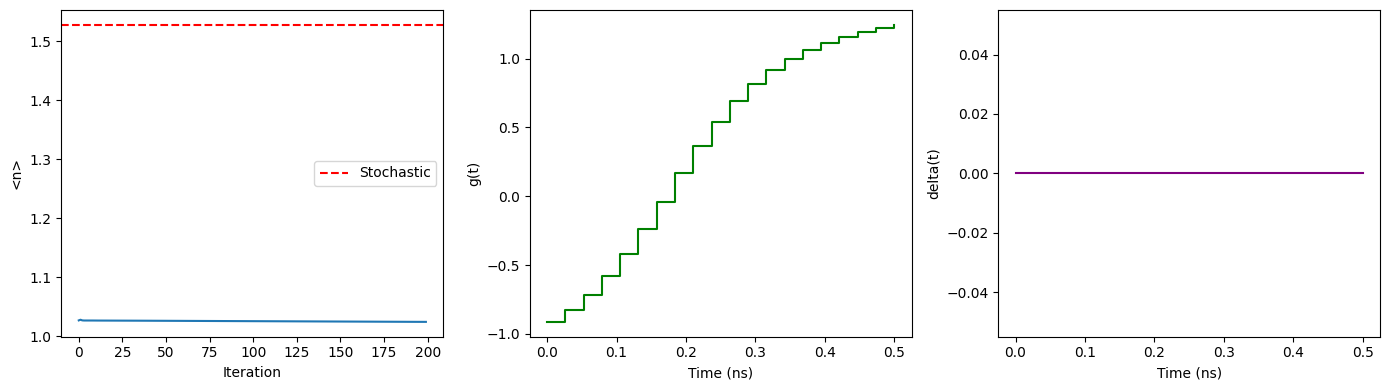

Stochastic limit: 1.5277
Improvement: 33.0%


In [10]:
# Plot GRAPE results
import matplotlib.pyplot as plt
import numpy as np

stoch = StochasticParams(
    omega_c=5.0, omega_a=5.0, kappa=0.05,
    T_bath=0.5, T_atom=0.05, lambda_ex=5.0,
    g=0.5, tau=0.05, R=5.0, chi=2.0,
)
n_stoch, _ = compute_stochastic_limit(stoch)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(history)
axes[0].axhline(n_stoch, color='r', linestyle='--', label='Stochastic')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('<n>')
axes[0].legend()

t = np.linspace(0, config.T_cycle, config.n_steps)
axes[1].step(t, optimal_cycle.g_sequence, 'g-', where='post')
axes[1].set_xlabel('Time (ns)')
axes[1].set_ylabel('g(t)')

axes[2].step(t, optimal_cycle.delta_sequence, 'purple', where='post')
axes[2].set_xlabel('Time (ns)')
axes[2].set_ylabel('delta(t)')

plt.tight_layout()
plt.savefig('results/grape_figure.png', dpi=300)
plt.show()

print(f"Stochastic limit: {n_stoch:.4f}")
print(f"Improvement: {(n_stoch - history[-1])/n_stoch*100:.1f}%")

In [11]:
# Download results
from google.colab import files
files.download(grape_path)
files.download('results/grape_figure.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. SAC Training (longer run)

In [12]:
# Train SAC agent (adjust timesteps as needed)
model, callback, env = train_sac(
    total_timesteps=50000,
    n_steps_per_cycle=20,
    n_cycles_per_episode=50,
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Step 2000: n_cav = 1.0467 (best: 1.0467)
Step 4000: n_cav = 0.9527 (best: 0.9527)
Step 6000: n_cav = 0.9571 (best: 0.9527)
Step 8000: n_cav = 0.9566 (best: 0.9527)
Step 10000: n_cav = 0.9596 (best: 0.9527)
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -902     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 74       |
|    time_elapsed    | 134      |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | 20.8     |
|    critic_loss     | 0.129    |
|    ent_coef        | 0.0556   |
|    ent_coef_loss   | -7.31    |
|    learning_rate   | 0.0003   |
|    n_updates       | 9899     |
---------------------------------
Step 12000: n_cav = 0.9599 (best: 0.9527)
Step 14000: n_cav = 0.9635 (best: 0.9527)
Step 16000: n_cav = 0.9620 (best: 0.9527)
Step 18000: n_cav = 0.9624 (best: 0.9527)
Step 20000: n_cav = 0.9493 (best: 0.9493)
------

In [13]:
# Evaluate SAC results
from src.rl import evaluate_trained_agent

results, g_seq, delta_seq = evaluate_trained_agent(model, env, n_eval_episodes=5)

best_n = min(r['n_cav'] for r in results)
print(f"Best n_cav: {best_n:.4f} (target: {n_stoch:.4f})")

Episode 1: n_cav = 0.9575, reward = -848.09
Episode 2: n_cav = 0.9575, reward = -848.09
Episode 3: n_cav = 0.9575, reward = -848.09
Episode 4: n_cav = 0.9575, reward = -848.09
Episode 5: n_cav = 0.9575, reward = -848.09
Best n_cav: 0.9575 (target: 1.5277)


In [14]:
# Save SAC results
sac_path = save_sac_results(
    results=results,
    g_seq=g_seq,
    delta_seq=delta_seq,
    output_dir="results",
    name="sac_gpu"
)
files.download(sac_path)

Saved SAC results to results/sac_gpu_20260104_021141.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
!cd /content/abouie_proj && git add results/* && git commit -m "add GRAPE results" && git push origin dev

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@a0f7a6251bc0.(none)')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/abouie_proj/results/* /content/drive/MyDrive/

: 